In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#based on https://jmetzen.github.io/2015-11-27/vae.html

class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    
    @param: session TensorFlow session to execute the network. Provided with tf.Session() or tf.InteractiveSession
    @param: network_architecture The network architecture for this VAE. The second hidden layer is optional!
        E.g., network_architecture = dict(n_hidden_1=20, # 1st layer encoder/decoder neurons
                                         n_hidden_2=20, # OPTIONAL: 2nd layer encoder/decoder neurons
                                         n_input=50, # data input
                                         n_z=10)  # dimensionality of latent space
    @param: optimizer Optimizer used for training the network. Provided optimizer needs to implement .minimize() function!
        E.g., optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    @param: transfer_fct Activation function after hidden layers.
    @param: batch_size Batch size used in training.
    @param: print_debug Prints debug messages of this class if set to True.
    """
    def __init__(self, session, network_architecture, optimizer, transfer_fct=tf.nn.tanh, batch_size=1, print_debug=True):
        self._print_debug = print_debug
        self.__print_debug("Start initializing variational autoencoder (VAE) ...")
        
        self._network_architecture = network_architecture
        self._transfer_fct=transfer_fct
        self._optimizer_provided = optimizer
        self._batch_size = batch_size
        self._has_2_hidden_layer = ('n_hidden_2' in network_architecture)
        self.__print_debug("Does VAE have 2 hidden layers? " + str(self._has_2_hidden_layer), 1)
        
        # Input
        self.X = tf.placeholder(tf.float32, shape=[None, network_architecture["n_input"]], name="input_X") 
        
        # create the whole variational autoencoder network 
        self.__create_network()
        
        self.__create_loss_optimizer()
        
        #launch a tensorflow session
        self._session = session
        self._train_saver = tf.train.Saver()

        #run the initializer for all tensorflow variables
        self._session.run(tf.global_variables_initializer())
        
        self.__print_debug("VAE ready to use!")

    def train_with_mini_batch(self, batch):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self._session.run((self.optimizer, self.cost), feed_dict={self.X: batch})
        return cost
    
    def encode_to_latent_space(self, x):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self._session.run(self.z_mean, feed_dict={self.X: x})
    
    def decode_from_latent_space(self, z):
        """ Generate data by sampling from latent space. """
        return self._session.run(self.x_reconstructed, feed_dict={self.z: z})
    
    def encode_and_decode(self, x):
        """ Use VAE to reconstruct given data. Encodes and decodes in the same run."""
        return self._session.run(self.x_reconstructed, feed_dict={self.X: x})
    
    def load_trained_model(self, save_path):
        ''' Loads trained model from disk. CAUTION: need to open session with 'tf.Session(graph=tf.Graph())'!'''
        self._train_saver.restore(self._session, save_path)
        self.__print_debug("Trained model found in '"+save_path+"' restored!")
        
    def save_trained_model(self, path):
        save_path = self._train_saver.save(self._session, path + "model.ckpt") #Saves the weights (not the graph)
        self.__print_debug("Model saved in file: {}".format(save_path))
        return save_path
    
    
    def calculate_z(self, X):
        return self._session.run(self.z, feed_dict={self.X: X})
    
    def calculate_z_mean(self, X):
        return self._session.run(self.z_mean, feed_dict={self.X: X})
        
    def __print_debug(self, message, indent=0):
        if self._print_debug:
            tabs=""
            for i in range(indent):
                tabs += "\t"
            print(tabs+message)

    def __create_network(self):
        self.__print_debug("Start creating VAE network ...", 1)
        #init weights and biases of all network nodes
        
        weights_and_biases = self.__init_weights_and_biases()
        
        #create the encoder network which generates the latent network
        self.z_mean, self.z_log_sigma_sq = \
            self.__create_encoder_network(weights_and_biases['weights_encoder'], 
                                          weights_and_biases['biases_encoder'])
            
        #create the sampling operation to:
        # -) map our data distribution to a normal distribution 
        # -) and secure a working backpropagation
        self.z = self.__create_z_sampling_operation()
        
        #create the decoder network which generates a reconstruction of input X
        self.x_reconstructed = \
            self.__create_decoder_network(weights_and_biases['weights_decoder'], 
                                          weights_and_biases['biases_decoder'])
        
        self.__print_debug("Finished creating VAE network!", 1)

        
    def __create_encoder_network(self, weights, biases):
        self.__print_debug("Start creating encoder network ...", 2)

        hidden_layer = self.__create_hidden_layer(self.X, weights, biases)
        
        # Parameters for the Gaussian
        z_mean = tf.matmul(hidden_layer, weights['z_mean']) + biases['z_mean']
        z_log_sigma_sq = tf.matmul(hidden_layer, weights['z_ls2']) + biases['z_ls2']
        
        self.__print_debug("Finished creating encoder network!", 2)
        
        return (z_mean, z_log_sigma_sq)
        
    def __create_z_sampling_operation(self):
        self.__print_debug("Start creating z (latent layer) sampling operation ...", 2)
        
        n_z = self._network_architecture['n_z']
        
        # Adding a random number from the normal (gaussian) distribution
        epsilon = tf.random_normal((self._batch_size, n_z), 0, 1, dtype=tf.float32) 

        # sample z from a normal (gaussian) distribution -> z = mu + sigma*epsilon
        z = self.z_mean + tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), epsilon)
        
        self.__print_debug("Finished creating z sampling operation!", 2)
        
        return z
    
    def __create_decoder_network(self, weights, biases):
        self.__print_debug("Start creating decoder/generator network ...", 2)
        
        hidden_layer = self.__create_hidden_layer(self.z, weights, biases)
        
        x_reconstructed = tf.matmul(hidden_layer,  weights['out']) + biases['out']
    
        self.__print_debug("Finished creating decoder/generator network!", 2)
            
        return x_reconstructed
    
    def __create_hidden_layer(self, x, weights, biases):
        self.__print_debug("Start creating hidden layer ...", 3)
        
        # First hidden layer
        hidden_layer_1 = tf.matmul(x, weights['h1']) + biases['h1']
        hidden_layer_1 = self._transfer_fct(hidden_layer_1)

        # Second hidden layer
        hidden_layer_2 = tf.matmul(hidden_layer_1, weights['h2']) + biases['h2']
        hidden_layer_2 = self._transfer_fct(hidden_layer_2)

        self.__print_debug("Finished creating hidden layer!", 3)
        
        return hidden_layer_2 if self._has_2_hidden_layer else hidden_layer_1
        
    def __init_weights_and_biases(self):
        self.__print_debug("Start initalizing weights and biases ...", 2)

        n_input = self._network_architecture['n_input']
        n_hidden_1 = self._network_architecture['n_hidden_1']
        n_hidden_2 = self._network_architecture['n_hidden_2'] if self._has_2_hidden_layer else 1
        n_hidden_out = n_hidden_2 if self._has_2_hidden_layer else n_hidden_1
        n_z = self._network_architecture['n_z']
        
        weights_and_biases = dict()
        
        #encoder
        weights_and_biases['weights_encoder'] = {
            'h1': self.__create_weight([n_input, n_hidden_1], "w_enc_h1"),
            'h2': self.__create_weight([n_hidden_1, n_hidden_2], "w_enc_h2"),
            'z_mean': self.__create_weight([n_hidden_out, n_z], "w_z_mean"),
            'z_ls2': self.__create_weight([n_hidden_out, n_z], "w_z_ls2")
        }
        weights_and_biases['biases_encoder'] = {
            'h1': self.__create_bias([n_hidden_1], "b_enc_h1"),
            'h2': self.__create_bias([n_hidden_2], "b_enc_h2"),
            'z_mean': self.__create_bias([n_z], "b_z_mean"),
            'z_ls2': self.__create_bias([n_z], "b_z_ls2")
        }
        
        #decoder
        weights_and_biases['weights_decoder'] = {
            'h1': self.__create_weight([n_z, n_hidden_1], "w_dec_h1"),
            'h2': self.__create_weight([n_hidden_1, n_hidden_2], "w_dec_h2"),
            'out': self.__create_weight([n_hidden_out, n_input], "w_out")
        }
        weights_and_biases['biases_decoder'] = {
            'h1': self.__create_bias([n_hidden_1], "b_dec_h1"),
            'h2': self.__create_bias([n_hidden_2], "b_dec_h2"),
            'out': self.__create_bias([n_input], "b_out")
        }
        self.__print_debug("Finished initalizing weights and biases!", 2)

        return weights_and_biases
    
    def __create_loss_optimizer(self):
        self.__print_debug("Start creating optimizer/backprop operation ...", 1)

        # The loss is composed of two terms:
        #according to the VAE tutorial paper:
        reconstr_loss = tf.reduce_sum(tf.square(tf.abs(self.X - self.x_reconstructed)), 1)
        #reconstr_loss = self.__l2_loss(self.x_reconstructed, self.X)
        #reconstr_loss = self.__cross_entropy(self.x_reconstructed, self.X)
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = self.__kullback_leibler(self.z_mean, tf.log(tf.sqrt(tf.exp(self.z_log_sigma_sq))))
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        self.optimizer = self._optimizer_provided.minimize(self.cost)

        self.__print_debug("Finished creating optimizer/backprop operation!", 1)

            
    def __create_weight(self, shape, name=""):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, dtype=tf.float32, name=name)
        #initial = tf.contrib.layers.xavier_initializer()
        #return tf.Variable(initial(shape), dtype=tf.float32, name=name)

    def __create_bias(self, shape, name=""):
        initial = tf.constant(0.1, shape=shape, dtype=tf.float32)
        return tf.Variable(initial, name=name)
        #return tf.Variable(tf.zeros(shape, dtype=tf.float32), name=name)
        #initial = tf.contrib.layers.xavier_initializer()
        #return tf.Variable(initial(shape), dtype=tf.float32, name=name)
        
    def __kullback_leibler(self, mu, log_sigma):
        """(Gaussian) Kullback-Leibler divergence KL(q||p), per training example"""
        # (tf.Tensor, tf.Tensor) -> tf.Tensor
        with tf.name_scope("KL_divergence"):
            # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
            return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)

    def __cross_entropy(self, obs, actual, offset=1e-7):
        """Binary cross-entropy, per training example"""
        # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
        with tf.name_scope("cross_entropy"):
            # bound by clipping to avoid nan (--> log(0))
            obs_ = tf.clip_by_value(obs, offset, 1 - offset)
            return -tf.reduce_sum(actual * tf.log(obs_) + (1 - actual) * tf.log(1 - obs_), 1)

    def __l2_loss(self, obs, actual):
        """L2 loss (a.k.a. Euclidean / LSE), per training example"""
        # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
        with tf.name_scope("l2_loss"):
            return tf.reduce_sum(tf.square(obs - actual), 1)

In [4]:
DEFAULT_MODEL_PATH = "./trained_vae/"

def train_vae(vae, weapon_data, batch_size=1, training_epochs=10, epoch_debug_step=5,
              trained_model_save_path=DEFAULT_MODEL_PATH, 
              save_model = True, save_model_every_epoch = True):
    
    num_samples = weapon_data.num_examples
    trained_model_path = ""
    
    #training cycle
    for epoch in range(num_epochs):
        avg_cost = 0.
        total_batch = int(num_samples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch = weapon_data.next_batch(batch_size)
            
            # Fit training using batch data
            cost = vae.train_with_mini_batch(batch)
            
            #compute average loss/cost
            avg_cost += cost / num_samples * batch_size

        # Display logs per epoch step
        if epoch % epoch_debug_step == 0:
            if save_model and save_model_every_epoch:
                trained_model_path = vae.save_trained_model(trained_model_save_path)
            print("Epoch:"+ '%04d' % (epoch+1) + ", cost=" + "{:.9f}".format(avg_cost))
            
    if save_model and not save_model_every_epoch:
        trained_model_path = vae.save_trained_model(trained_model_save_path)
    
    if save_model:
        print("Trained model saved! You can find it in '"+trained_model_path+"'")

#just a convenience wrapper
def get_untrained_vae(session, network_architecture, optimizer, transfer_fct, batch_size=1):
    
    return VariationalAutoencoder(session=session, network_architecture=network_architecture, optimizer=optimizer, 
                                 transfer_fct=transfer_fct, batch_size=batch_size, print_debug=False)

#just a convenience wrapper
def get_new_trained_vae(session, weapon_data, network_architecture, optimizer, transfer_fct,
                          batch_size=1, training_epochs=10, epoch_debug_step=5,
                          trained_model_save_path=DEFAULT_MODEL_PATH, 
                          save_model = True, save_model_every_epoch = True):

    #create vae
    vae = get_untrained_vae(session=session, network_architecture=network_architecture, optimizer=optimizer, 
                                 transfer_fct=transfer_fct, batch_size=batch_size)
    
    #train it
    vae = train_vae(vae, weapon_data, batch_size, training_epochs, epoch_debug_step, 
                       trained_model_save_path, save_model, save_model_every_epoch)
        
    return vae

#just a convenience wrapper
def restore_vae(untrained_vae, model_path):
    untrained_vae.load_trained_model(model_path)
    return untrained_vae
    

In [5]:
#test utils

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)

In [6]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=14,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    weapon_data = weapons.DataSet(seed=19071991) 
    network_architecture['n_input'] = weapon_data.num_features
  
    vae = get_new_trained_vae(sess, weapon_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001, cost=24.254438684
Epoch:0002, cost=21.861828524
Epoch:0003, cost=19.749310435
Epoch:0004, cost=17.830332134
Epoch:0005, cost=17.137048847
Epoch:0006, cost=14.804081640
Epoch:0007, cost=14.060663368
Epoch:0008, cost=14.799999667
Epoch:0009, cost=12.446837770
Epoch:0010, cost=13.160067779
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [7]:

with tf.Session(graph=tf.Graph()) as sess:
    vae = get_untrained_vae(sess, network_architecture, optimizer, transfer_fct, batch_size)
    vae = restore_vae(vae, "trained_vae/model.ckpt")
        
    weapon_data = weapons.DataSet(seed=19071991) 
    samples = weapon_data.next_batch(batch_size)
    x_reconstructed = vae.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(weapon_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[-0.70326645 -0.48674743 -0.30162464 -0.29826301 -0.22336265  1.3003496
  -0.75793673 -0.59816232  0.19378264 -1.11913753 -0.86609068 -0.28002455
   0.55030494  2.19514536  3.58362519  0.55859823 -0.28577464 -0.32322997
  -0.50421948 -0.54611868 -0.36023741 -0.52522573  2.45919073 -0.2672411 ]]
[[-0.8756247  -0.51307255 -0.46652347 -0.48351285 -0.09164627  1.3460879
  -0.7955996  -0.56146747  1.2990477  -0.57705593 -0.8507605  -0.13715252
   0.11545181  0.55893874  0.3069438   1.3266746  -0.1432753  -0.40696168
  -0.4218165  -0.40320772  0.9521485  -0.32813042  0.88883924 -0.20152833]]
damages_first = ['26.5', '22.233594628702704']
damages_last = ['20.0', '19.368608812548743']
dmg_distances_first = ['11.0', '8.549149101995123']
dmg_distances_last = ['50.0', '42.274955501132496']
drag = ['0.0024999999441206455', '0.002659377651834734']
firemode_Automatic = ['1.0', '1.0221025000409791']
firemode_Semi-Automatic = ['0.0', '-

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


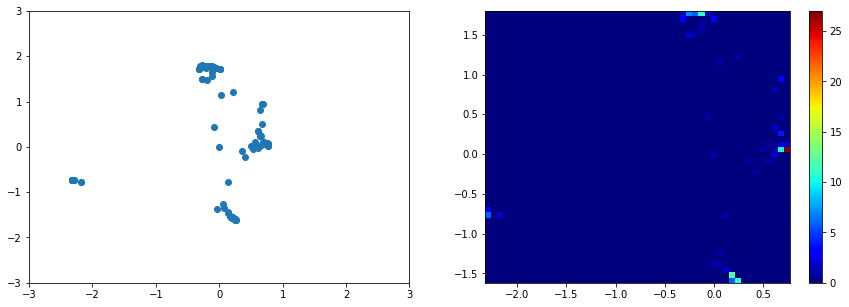

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

all_z = np.zeros((1,network_architecture['n_z']))
with tf.Session(graph=tf.Graph()) as sess:
    vae = get_untrained_vae(sess, network_architecture, optimizer, transfer_fct, batch_size)
    vae = restore_vae(vae, "trained_vae/model.ckpt")
    
    weapon_data = weapons.DataSet(seed=19071991) 
    total_batch = int(weapon_data.num_examples / batch_size) 
    
    # Loop over all batches
    for i in range(total_batch):
        batch = weapon_data.next_batch(batch_size)
        z_mean = vae.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_mean))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()

In [19]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    vae = get_untrained_vae(sess, network_architecture, optimizer, transfer_fct, batch_size)
    vae = restore_vae(vae, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = vae.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    weapon_data = weapons.DataSet(seed=19071991) 
    print_decoded_tensors_as_dict(weapon_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['90.9313774012717', '37.43811763273066', '33.10123002171909', '24.6148019660377']
damages_last = ['68.5089369609525', '17.624477976991365', '19.16248637763192', '18.613666667179494']
dmg_distances_first = ['7.519778608077821', '20.913327302867074', '17.55593384716672', '10.87909001393608']
dmg_distances_last = ['119.3850092349387', '40.28082392105604', '42.12210882891269', '41.13229526474803']
drag = ['0.0022201657393044662', '0.002905896959056628', '0.0025450090387301853', '0.0027096591777627083']
firemode_Automatic = ['-0.029967369225196716', '0.12300466088913897', '0.42850111170699984', '0.8675256979105361']
firemode_Semi-Automatic = ['0.06538128149936795', '0.8510658647349805', '0.5904633220979767', '0.15572371607021407']
hiprecoildec = ['3.8497985207646543', '4.818307415206965', '6.267057114297727', '8.272315281484177']
hiprecoilright = ['1.044191286303061', '0.5824521250367651', '0.4694656390614766'